## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

2022-12-10 16:03:51.604979: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
tf.__version__

'2.4.1'

## Import Dataset

In [3]:
BATCH_SIZE = 64
IMG_WIDTH = 30
IMG_HEIGHT = 30

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory='Train-Data/',
    validation_split=0.2,
    subset='training',
    seed=42,
    color_mode='grayscale',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='bilinear',
    batch_size=BATCH_SIZE)

Found 70645 files belonging to 36 classes.
Using 56516 files for training.


2022-12-10 16:04:19.995385: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-10 16:04:20.127681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-10 16:04:20.373707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 16:04:20.374128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce MX150 computeCapability: 6.1
coreClock: 1.5315GHz coreCount: 3 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 44.76GiB/s
2022-12-10 16:04:20.374180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-10 16:04:21.125550: I tensorflow/stream_executor/platform/defaul

In [5]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    directory='Train-Data/',
    validation_split=0.2,
    subset='validation',
    seed=42,
    color_mode='grayscale',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    interpolation='bilinear',
    batch_size=BATCH_SIZE)

Found 70645 files belonging to 36 classes.
Using 14129 files for validation.


Shape of one batch:
 (64, 30, 30, 1) 

Labels of first batch:
 tf.Tensor(
[15  7 11 35 26 24 12 14  0 19 12  5 31  4  3 25  3  1 28 10  5 19 32 12
 35 29  4 25 35 35 32 31  3 24 33 25 18 20 10 24  1  9 24 26 17 23  5 25
  7 33  1 31 19 21 32  3 12 13 19 12 33  9 31 12], shape=(64,), dtype=int32)


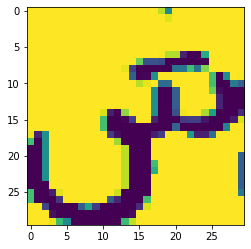

In [11]:
for batch, labels in train_ds:
    print("Shape of one batch:\n", batch.shape, "\n")
    print("Labels of first batch:\n", labels)
    img = batch[48]
    break

plt.imshow(img)

## Create Model

In [22]:
# Create Model
OCR_model = keras.models.Sequential([
    keras.layers.Conv2D(64, 5, input_shape=(30, 30, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.ReLU(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(128, 5),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(250),
    keras.layers.ReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(35, activation=tf.nn.log_softmax)
])

In [23]:
# Compile Model
OCR_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics='accuracy')

In [29]:
OCR_model.fit()

<bound method DatasetV2.batch of <BatchDataset shapes: ((None, 30, 30, 1), (None,)), types: (tf.float32, tf.int32)>>

## Training Model

## Evaluation Model